In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

In [66]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,83.039513,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.593086,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,85.034225,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,85.139702,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,84.516357,7296900


<AxesSubplot:title={'center':'Star Bucks Stock Volume'}, xlabel='Date'>

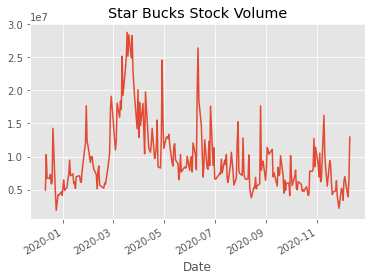

In [67]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Star Bucks Stock Volume')

In [68]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]

In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

In [70]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :]

In [71]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [72]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [73]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [74]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [75]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [76]:

num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [77]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [78]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [79]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04486
Epoch: 100, loss: 0.02215
Epoch: 200, loss: 0.01607
Epoch: 300, loss: 0.01395
Epoch: 400, loss: 0.01260
Epoch: 500, loss: 0.01176
Epoch: 600, loss: 0.01138
Epoch: 700, loss: 0.01117
Epoch: 800, loss: 0.01102
Epoch: 900, loss: 0.01089


In [90]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

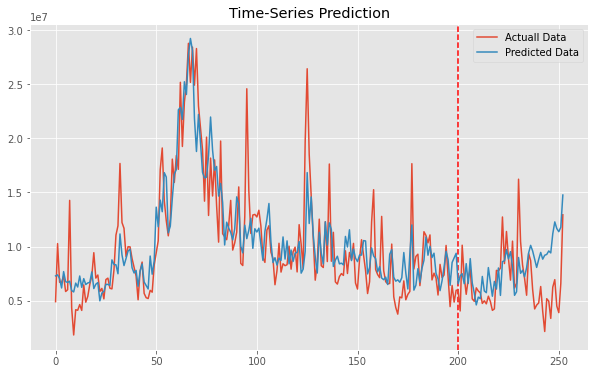

In [81]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [117]:
# test = torch.randn(2, 5)
test = torch.tensor([[0.3847, 0.3659, 0.4264, 0.4400, 0.4839]])

test = torch.reshape(test, (test.shape[0], 1, test.shape[1]))
print(test.shape)
print(test)

test_predict = lstm1(test)
test_predict_conv = test_predict.data.numpy()

print(test_predict_conv.shape)
print(test_predict_conv)

print(mm.inverse_transform(test_predict_conv))

torch.Size([1, 1, 5])
tensor([[[0.3847, 0.3659, 0.4264, 0.4400, 0.4839]]])
(1, 1)
[[0.1753537]]
[[6568812.5]]


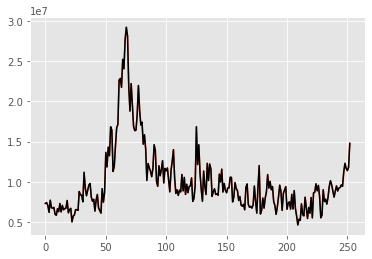

In [123]:
predictions = []
for value in df_X_ss:
    test = torch.reshape(value, (value.shape[0], 1, value.shape[1]))
    test_predict = lstm1(test)
    test_predict_conv = test_predict.data.numpy()
    predictions = np.append(predictions, mm.inverse_transform(test_predict_conv))

plt.plot(predictions)
plt.plot(data_predict, label='Predicted Data', color='k')